# **New Aviation Fleet Acquisition Risk Analysis**


## *Introduction*



This analysis uses the aviation dataset to allow us to quantify the overall risk associated with different types of aircraft and identify which configurations have historically demonstrated safer performance.Specifically, using aircraft category, engine type, number of engines, and manufacturer (make) relate to historical accident outcomes, including injury severity, aircraft damage, and counts of fatal, serious, minor, and uninjured passengers. By interpreting injury and damage patterns across manufacturers and engine setups, we can provide clear guidance on which aircraft types pose lower operational risk and are therefore better suited for our company’s entry into commercial and private aviation services.

In the cell below we import the relevant libraries to be used for the Analysis.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


This part of code shows how to load the Data, select the necessary relevant columns to be used to achieve our goal for this analysis

In [32]:

df = pd.read_csv(
    "AviationData.csv",
    encoding="latin1",
    low_memory=False
)

# Loading Relevant columns for the study
cols = [
    "Aircraft.Category",
    "Injury.Severity",
    "Aircraft.damage",
    "Number.of.Engines",
    "Engine.Type",
    "Make",
    "Total.Fatal.Injuries",
    "Total.Serious.Injuries",
    "Total.Minor.Injuries",
    "Total.Uninjured",
]

We have already selected the relevant columns we need successfully.Now, we are now looping through each column name in the list cols to compare their existence with the provided dataset anf helps us to identify which column exactly is missing.

In [33]:
for c in cols:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")
df = df[cols].copy()

### *Dealing with Missing Values*
This code fills missing values in specific categorical columns with the label "Unknown". Creates a list of column names
 that are categorical (text-based, not numeric) and loops through each column name in the list and replaces missing values with Unknown and assigns it back to the dataframe. This keeps all rows ensuring no data loss.

In [35]:
cat_cols = ["Aircraft.Category", "Injury.Severity", "Aircraft.damage", "Engine.Type", "Make"]
for c in cat_cols:
    df[c] = df[c].fillna("Unknown")


This function is designed to clean and standardize the “number of engines” field so that it becomes a usable numeric value. Try is a protective block that ensures the code does not crush if it fails.

In [42]:
#Parse Number.of.Engines into integer where possible
def parse_num_engines(x):
    try:
        if pd.isna(x):
            return np.nan
        if isinstance(x, (int, float)):
            if np.isnan(x):
                return np.nan
            return int(x)
        s = str(x).strip().lower()
        if s == '':
            return np.nan
        #simpler mapping to values
        map_words = {"one":1,"single":1,"two":2,"twin":2,"three":3,"four":4}
        for w,v in map_words.items():
            if w in s:
                return v
            #digits
            import re
        m = re.search(r"\d+", s)
        if m:
            return int(m.group())
        return np.nan
    except Exception:
        return np.nan
df["no.of.engines_parsed"] = df["Number.of.Engines"].apply(parse_num_engines)

    #Fill with mode if still missing
if df["no.of.engines_parsed"].dropna().empty:
    mode_eng = 1
else:
    mode_eng = int(df["no.of.engines_parsed"].mode().iloc[0])
df["no.of.engines_parsed"] = df["no.of.engines_parsed"].fillna(mode_eng).astype(int)
df["no.of.engines_imputed"] = df["no.of.engines_parsed"].isna()

# Numeric injury fill and imputation flags
num_inj_cols = ["Total.Fatal.Injuries", "Total.Serious.Injuries", "Total.Minor.Injuries", "Total.Uninjured"]
for c in num_inj_cols:
    df[c + "_imputed_flag"] = df[c].isna()
    df[c] = df[c].fillna(0).astype(int)

# Derived flags/metrics
df["total_injuries_reported"] = (df["Total.Fatal.Injuries"] + df["Total.Serious.Injuries"]
                                 + df["Total.Minor.Injuries"] + df["Total.Uninjured"])
df["had_fatal"] = (df["Total.Fatal.Injuries"] > 0).astype(int)
df["had_serious"] = (df["Total.Serious.Injuries"] > 0).astype(int)


### *Aggregating Data*
This part summarizes accident risk statistics for different aircraft groupings (make, category, engine type, number of engines etc). It groups the data and performs operations like count, sum to know the severity impact per category, binary flags (0 or 1 per accident),Summing them gives the number of accidents that involved at least one fatal or serious injury.
This derives risk metrics hence providing a wholesum conclusive argument of our findings to derive relevant concerete conclusions.

In [48]:
def aggregate_group(df, by_cols, min_records=30):
    g = df.groupby(by_cols).agg(
        records=('Make','count'),
        total_fatal=('Total.Fatal.Injuries','sum'),
        total_serious=('Total.Serious.Injuries','sum'),
        total_minor=('Total.Minor.Injuries','sum'),
        total_uninjured=('Total.Uninjured','sum'),
        incidents_with_fatal=('had_fatal','sum'),
        incidents_with_serious=('had_serious','sum'),
    ).reset_index()
    g["avg_fatal_per_record"] = g["total_fatal"] / g["records"]
    g["prop_incidents_with_fatal"] = g["incidents_with_fatal"] / g["records"]
    g["avg_serious_per_record"] = g["total_serious"] / g["records"]


    # optionally filter small-sample groups
    g_filtered = g[g["records"] >= min_records].copy()
    return g, g_filtered

make_agg, make_agg_filtered = aggregate_group(df, ["Make"], min_records=30)
category_agg, category_agg_filtered = aggregate_group(df, ["Aircraft.Category"], min_records=10)
engine_type_agg, engine_type_agg_filtered = aggregate_group(df, ["Engine.Type"], min_records=10)
engines_count_agg, engines_count_agg_filtered = aggregate_group(df, ["no.of.engines_parsed"], min_records=10)

#Present Top to Bottom Results
print("Top 10 safest makes by avg_fatal_per_record (filtered >=30 records):")
print(make_agg_filtered.sort_values("avg_fatal_per_record").head(10)[["Make","records","avg_fatal_per_record","prop_incidents_with_fatal"]])

print("\\nTop 10 worst makes by prop_incidents_with_fatal (filtered >=30 records):")
print(make_agg_filtered.sort_values("prop_incidents_with_fatal", ascending=False).head(10)[["M"
"ake","records","avg_fatal_per_record","prop_incidents_with_fatal"]])


Top 10 safest makes by avg_fatal_per_record (filtered >=30 records):
                                Make  records  avg_fatal_per_record  \
2929  GRUMMAN ACFT ENG COR-SCHWEIZER       58              0.017241   
6176                           Raven       86              0.046512   
6717                         STINSON       91              0.054945   
3176               Grumman-schweizer      121              0.057851   
1434  COSTRUZIONI AERONAUTICHE TECNA       31              0.064516   
3597                          Hiller      311              0.083601   
7061                            Snow       32              0.093750   
2352              Eagle Aircraft Co.       42              0.095238   
225               AVIAT AIRCRAFT INC       72              0.097222   
864                    Balloon Works      139              0.100719   

      prop_incidents_with_fatal  
2929                   0.017241  
6176                   0.034884  
6717                   0.032967  
3176         

### *Static plots (matplotlib)*


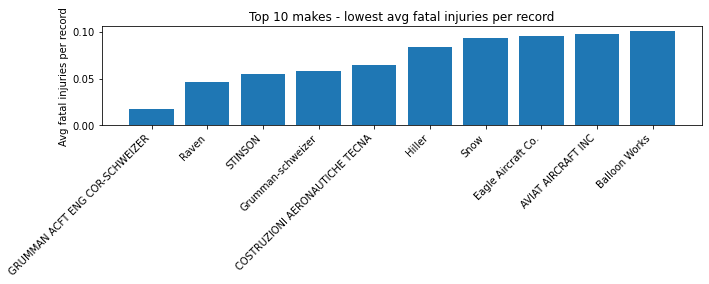

In [54]:
# Plot A: Top 10 lowest avg_fatal_per_record
top_safe = make_agg_filtered.sort_values("avg_fatal_per_record").head(10)
plt.figure(figsize=(10,4))
plt.bar(range(len(top_safe)), top_safe["avg_fatal_per_record"])
plt.xticks(range(len(top_safe)), top_safe["Make"], rotation=45, ha="right")
plt.ylabel("Avg fatal injuries per record")
plt.title("Top 10 makes - lowest avg fatal injuries per record")
plt.tight_layout()
plt.show()

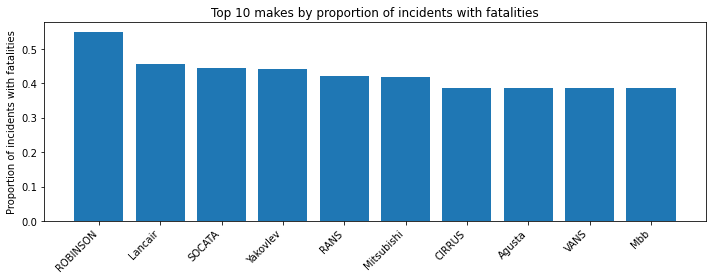

In [53]:
# Plot B: Worst 10 by proportion incidents with fatalities
worst_by_prop = make_agg_filtered.sort_values("prop_incidents_with_fatal", ascending=False).head(10)
plt.figure(figsize=(10,4))
plt.bar(range(len(worst_by_prop)), worst_by_prop["prop_incidents_with_fatal"])
plt.xticks(range(len(worst_by_prop)), worst_by_prop["Make"], rotation=45, ha="right")
plt.ylabel("Proportion of incidents with fatalities")
plt.title("Top 10 makes by proportion of incidents with fatalities")
plt.tight_layout()
plt.show()

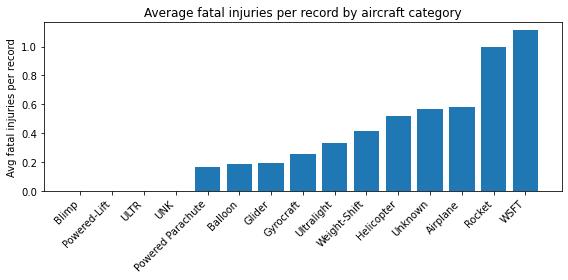

In [56]:
# Plot C: By aircraft category
cat = category_agg.sort_values("avg_fatal_per_record")
plt.figure(figsize=(8,4))
plt.bar(range(len(cat)), cat["avg_fatal_per_record"])
plt.xticks(range(len(cat)), cat["Aircraft.Category"], rotation=45, ha="right")
plt.ylabel("Avg fatal injuries per record")
plt.title("Average fatal injuries per record by aircraft category")
plt.tight_layout()
plt.show()